# Air Pollution Model Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spilu, LinearOperator, gmres, spsolve
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm

%matplotlib inline

## 1D Numerical Simulation

In this section we seek to compare the analytical solution and our numerical approximation to ensure our scheme works in 1D before scaling it to 2D. We chose not to include a 1D simulation on our report because we believed it would not contribute to the depth and applicability of our proposed model. Nevertheless, when picking our numerical scheme and designing our tridiagonal matrix we first began with a 1D toy model which has both advection and diffusion in the x direction. This is left here for completeness.

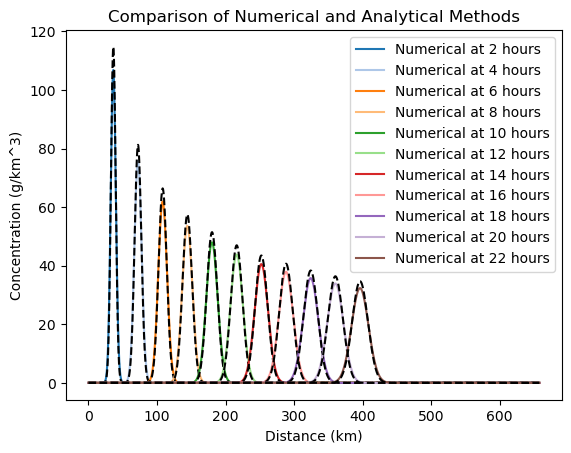

Approximate Mass Error of Numerical Method is 0.0000%.


In [2]:
# Initial Gaussian puff function as an approximation to point source

def I_simple(x, Mass, D, Release_Location, dt):  # Initial Gaussian Curve
    """
    Computes the initial concentration of a Gaussian puff as an approximation 
    to a point source release.

    The Gaussian function models the concentration of the pollutant at time 
    `dt` after it has been released from a specified location.

    Parameters:
    x (numpy.ndarray): Array of spatial points where the concentration is evaluated.
    Mass (float): Total mass of the pollutant released.
    D (float): Diffusion coefficient.
    Release_Location (float): The x-coordinate of the point source.
    dt (float): Time increment since the release.

    Returns:
    numpy.ndarray: The computed concentration at each point in `x`.
    """
    return Mass / (np.sqrt(4 * D * np.pi * dt)) * np.exp(-((x - Release_Location) ** 2) / (4 * D * dt))


# Analytical Solution function
def concentration_exact(x, t, D, V, M, b):
    """
    Computes the exact concentration of a pollutant at a given time using 
    our analytical solution for diffusion and advection in 1 Dimension.

    Parameters:
    x (numpy.ndarray): Array of spatial points where the concentration is evaluated.
    t (float): Time at which to compute the concentration.
    D (float): Diffusion coefficient.
    V (float): Velocity of advection.
    M (float): Total mass of the pollutant.
    b (float): Initial position offset of the pollutant.

    Returns:
    numpy.ndarray: The computed concentration at each point in `x` at time `t`.
    """
    a = M / (np.sqrt(4 * np.pi * D * t))
    
    return a * np.exp(-((x - b - V * t) ** 2) / (4 * D * t))


def concentration_approx(D, A, M, Release_Location, theta = 0.5, Timetotal =24, Total_space =1000, Time_Resolution = 60, Space_Resolution = 20):
    """
    Computes the numerical concentration of a pollutant over time and space 
    using an implicit finite difference method.

    The function simulates the diffusion and advection of a pollutant 
    released at a specific location, using a tridiagonal matrix for 
    implicit time-stepping.

    Parameters:
    D (float): Diffusion coefficient.
    A (float): Advection coefficient.
    M (float): Total mass of the pollutant.
    Release_Location (float): The x-coordinate of the point source.
    theta (float): Weighting factor for the implicit scheme (default is 0.5).
    Timetotal (float): Total simulation time in hours (default is 24).
    Total_space (float): Total spatial length in kilometers (default is 1000).
    Time_Resolution (int): Number of time steps per hour (default is 60).
    Space_Resolution (int): Number of spatial steps per kilometer (default is 20).

    Returns:
    tuple: A tuple containing the concentration matrix, initial conditions, 
           number of spatial points, spatial array, spatial step size, 
           number of time steps, time array, time step size, and starting index.
    """
    
    # Time Parameters
    T =  Timetotal           # Total time (hours)
    Nt = T * Time_Resolution       # Number of timesteps (so that time is discretized in minutes)
    dt = 1/ Time_Resolution      # Discretization in time
    t_i = np.arange(0, T, dt ) # Discretize space in array

    # Space Parameters  
    L = Total_space      # Space length (km)
    Nx = L * Space_Resolution     # Number of spaces in x step size will be every 10 meters
    dx = 1 / Space_Resolution        # Discretization in space
    x = np.arange(-20, L - 20, dx ) # Discretize space in array
    
    
    
    # Initialize concentration array
    c_old = np.zeros_like(x)

    # Set up initial condition
    c_old += I_simple(x, M, D, Release_Location, dt) # Initial larger diffusion value for stability
    IC = c_old
    # Precompute constants for implicit scheme
    r = D * dt / (dx ** 2) # Courant Number
    p = A * dt / (dx) # Fourier Number

    # Set up the tridiagonal matrix A in LHS for implicit Euler
    subdiagonal_A = -theta*(r + p)
    diagonal_A = 1 + theta*(2 * r +p)
    superdiagonal_A =  -theta * r 

    # Tridiagonal matrix (A)
    A_matrix = lil_matrix((Nx,Nx))
    # Fill the tridiagonal matrix A
    for i in range(1, Nx - 1):
        A_matrix[i, i - 1] = subdiagonal_A  # Subdiagonal
        A_matrix[i, i] = diagonal_A        # Diagonal
        A_matrix[i, i + 1] = superdiagonal_A  # Superdiagonal
        

    # Set up the tridiagonal matrix A in LHS for implicit Euler
    subdiagonal_B = (1-theta)*(r + p)
    diagonal_B = 1 + (1-theta)*-1*(2 * r +p)
    superdiagonal_B =  (1-theta)* r


    B_matrix = lil_matrix((Nx,Nx))
    # Fill the tridiagonal matrix B
    for i in range(1, Nx - 1):
        B_matrix[i, i - 1] = subdiagonal_B  # Subdiagonal
        B_matrix[i, i] =  diagonal_B       # Diagonal
        B_matrix[i, i + 1] = superdiagonal_B  # Superdiagonal   

    # Boundary conditions Dirichlet on Left and Absorbing on Right
    A_matrix[0, 0] = 1
    A_matrix[-1, -2] = -theta * p
    A_matrix[-1, -1] = 1 + p * theta

    B_matrix[0, 0] = 1
    B_matrix[-1, -2] = p * (1 - theta)
    B_matrix[-1, -1] = 1 -p * (1 - theta)

    # Storage Matrix

    C = lil_matrix((Nx,Nt))
    C[:,0] = c_old[:]

    # Convert matrices to CSR format

    A_matrix = A_matrix.tocsr()
    B_matrix = B_matrix.tocsr()
    #C = C.tocsr()
    
    # Time-stepping loop for implicit Euler
    for t in range(1, Nt):
        # Solve the system A * c_new = c_old
        RHS =  B_matrix@c_old
        c_new = spsolve(A_matrix, RHS)
        
        # Update the old concentration with the new one
        c_old = c_new
    
        # Update Storage Matrix
        C[:,t] = c_old

    start = 20 * Space_Resolution
    
    return C, IC, Nx, x, dx, Nt, t_i , dt, start

# Compute Pollution spread for testing against analytical solution

# Chimney Parameters

Mass = 1000 # Mass of pollutant for instantaneous burst (kg)
Release_Location = 0 # Location of Chimney in the x-axis

# Define Advection and Diffusion 
D = 3   # Recommend to use Diffusion value D > 1 for stability under semi-implicit scheme (theta = 0.5) 
A = 18

# Set right boundary based on wind speed
L = int(np.ceil(1.5*(20+ A * 24)))

Concentration_test, IC_test, Nx, x, dx, Nt, t_i , dt, start = concentration_approx(D,A,Mass,Release_Location,Total_space= L)

# Compute Pollution spread for testing using analytical solution
Exact = np.zeros((Nx,Nt))

for n,t in enumerate(t_i):
  if n == 0:
    Exact[:,n] = I_simple(x,Mass, D , Release_Location, dt)
  
  else:
    Exact[:,n] = concentration_exact(x, t, D, A, Mass, Release_Location)


# Plot Comparison of Numerical and Analytical Results

# Set up the color palette for plots
colors = [cm.get_cmap('tab20')(i) for i in range(20)] 
m = 0 # Counter for color cycling


for t in range(121,Nt,120):
    
    plt.plot(x[start:], Concentration_test.getcol(t).toarray().flatten()[start:] , label=f'Numerical at {t * dt:.0f} hours', color=colors[m])
    if m == 11:
        plt.plot(x[start:], Exact[start:,t], '--k', label = "Exact Solution")
    else:
        plt.plot(x[start:], Exact[start:,t], '--k')
    m+= 1


plt.xlabel('Distance (km)')
plt.ylabel('Concentration (g/km^3)')
plt.title('Comparison of Numerical and Analytical Methods')
plt.legend()
plt.show()


# Test for Conservation of Mass 
Error_Backward = abs(Mass - np.trapz(Concentration_test.getcol(-1).toarray().flatten(), dx =dx )) / Mass * 100

print(f"Approximate Mass Error of Numerical Method is {Error_Backward:.4f}%.")
  

## 2D Numerical Simulation

We now proceed with the main segment in our project, attempting to approximate our 2 dimensional PDE.

### Initial Condition and General Parameter Setup

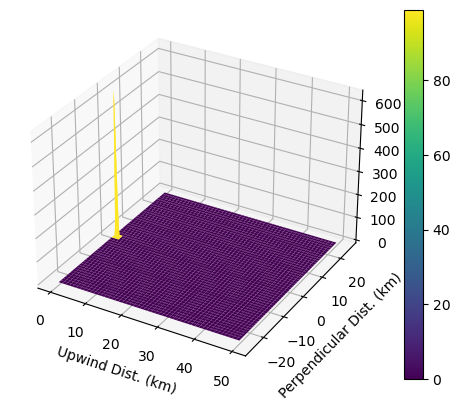

In [3]:
# Time Parameters

T = 1    # Total time (hours)
Nt = T * 60      # Number of timesteps (Every minute)
dt = T / Nt        # Discretization in time
t_i = np.arange(0, T, dt ) # Discretized time array

# Space Parameters  

L = 50 # Space length (km)
Space_Resolution = 10 # Define grid resolution
Nx = L * Space_Resolution # Number of spaces in x
Ny = L * Space_Resolution  # Number of spaces in y
dx = L / Nx  # Discretization in x
dy = L / Ny  # Discretization in y
x = np.arange(0, L, dx)
y = np.arange(0, L, dy)


# Chimney Parameters

Mass = (356400 / 24) / Nt # This is based on the approximate minute release rate in our report
Release_Width = 0.25  # Fixes the width of the Gaussian Curve to a small relative width
Release_Concentration = Mass/ (2 * np.pi * Release_Width**2)  # Manually fixes the peak of our Gaussian Curve so that it integrates to Mass as required
gap = int(np.round(4*Release_Width,0))
Release_Location = np.array([gap, L/2])  # Places the chimney minimally away from bounday for stability

# Diffusion Coefficients
D = 2.312e-3 * x ** 0.788 # This is based on our D_y(x) report formula

# Advection Coefficients (For testing advection effect on maximum concentration)
windspeeds = np.array([9, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10, 10.1]) * 3.6 # Original values in m/s and rescaled to km/h

# Create a 2D grid
X, Y = np.meshgrid(x, y)

# Initialize concentration array
c_old = np.zeros((Nx, Ny))

# Initial Gaussian puff function as approximation to point source
def gauss_2d(a, x, y, b_x, b_y, sigma):
    """
    Computes the value of a 2D Gaussian function at given points (x, y).
    
    The Gaussian function is defined as:
        G(x, y) = a * exp(-(((x - b_x)^2 + (y - b_y)^2) / (2 * sigma^2)))
    
    Parameters:
    a (float): Amplitude of the Gaussian peak.
    x (numpy.ndarray): Array of x-coordinates where the Gaussian is evaluated.
    y (numpy.ndarray): Array of y-coordinates where the Gaussian is evaluated.
    b_x (float): x-coordinate of the Gaussian center.
    b_y (float): y-coordinate of the Gaussian center.
    sigma (float): Standard deviation, which controls the width of the Gaussian.

    Returns:
    numpy.ndarray: An array containing the computed Gaussian values at each (x, y) point.
    """
    return a * np.exp(-(((x - b_x) ** 2) + ((y - b_y) ** 2)) / (2 * sigma ** 2))

# Set up initial condition
c_old = gauss_2d(Release_Concentration, X, Y, Release_Location[0], Release_Location[1], Release_Width)
IC_flat = c_old.flatten()


# Plot IC
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y - L / 2, c_old, cmap = 'viridis')
ax.set_xlabel('Upwind Dist. (km)')
ax.set_ylabel('Perpendicular Dist. (km)')
fig.colorbar(surf)
plt.show()

### Boundary Condition and Implicit Scheme Setup

Important Note: Because we are working with what is essentially a pure advection equation in one dimension and a pure diffusion equation in the other, we have chosen to work with an Implicit scheme and not a hybrid scheme like in the 1D case. This is mainly due to the fact that the advantage of a hybrid scheme is not substantial in this case (best for advection-diffusion in both directions) and therefore not having to create a second tridiagonal matrix proves to be very computationally beneficial.

In [4]:
def matrix_cons(u):
    """
    Constructs a tridiagonal matrix for the implicit Euler method used 
    in solving the 2D diffusion equation with Dirichlet boundary conditions.
    
    Parameters:
    u (float): The velocity used in the calculation, which affects the 
               Courant and Fourier numbers for the spatial discretization.

    Returns:
    scipy.sparse.csc_matrix: A compressed sparse column (CSC) matrix 
                              representation of the tridiagonal matrix 
                              used in the implicit Euler scheme.
    """
    
    # Courant and Fourier numbers (for both x and y)
    
    r = D * u * dt / dx ** 2  # Fourier Number for Diffusion in y
    p_x = u * dt / dx   #Courant Number for Advection in x

    # Initialize the tridiagonal matrix for Implicit Euler in x and y directions
    N = Nx * Ny
    A_matrix = lil_matrix((N,N))

    # Set up matrix coefficients
    alpha_x = -p_x
    alpha_y = -r
    beta = 1 + 2 * r + p_x
    gamma=  -r
    
    for k in range(Nx, N - Nx): # Only Loop through indices that are outside Left and Right Boundaries
        i = math.floor(k / Nx)
        j = k % Nx
        A_matrix[k, i * Nx + j] = beta[j]       # Main diagonal: self-coupling term at (k, k)
        A_matrix[k, (i - 1) * Nx + j] = alpha_y[j]  # Near sub-diagonal: one column left
        A_matrix[k, i * Nx + j - 1] = alpha_x   # Far sub-diagonal: Nx columns to the left
        A_matrix[k, (i + 1) * Nx + j] = gamma[j]    # Near super-diagonal: one column right   
        
    #Dirichlet / Absorbing Condition at Top and Bottom Boundaries
        
    for k in range(Nx, N - Nx, Nx):
        i = math.floor(k / Nx)
        j = k % Nx
        A_matrix[k, i * Nx + j] = 1   # Main diagonal: self-coupling term at (k, k)
        A_matrix[k, (i - 1) * Nx + j] = 0 # Near sub-diagonal: one column left
        A_matrix[k, i * Nx + j - 1] = 0   # Far sub-diagonal: Nx columns to the left
        A_matrix[k, (i + 1) * Nx + j] = 0   # Near super-diagonal: one column right
        
    for k in range(2 * Nx - 1, N - Nx, Nx):
        i = math.floor(k / Nx)
        j = k % Nx
        A_matrix[k, i * Nx + j] = 1   # Main diagonal: self-coupling term at (k, k)
        A_matrix[k, (i - 1) * Nx + j] = 0 # Near sub-diagonal: one column left
        A_matrix[k, i * Nx + j - 1] = 0   # Far sub-diagonal: Nx columns to the left
        A_matrix[k, (i + 1) * Nx + j] = 0   # Near super-diagonal: one column right

    # Dirichlet Condition at Left and Right Boundaries
    
    A_matrix[:Nx, :Nx] = np.eye(Nx)
    A_matrix[N - Nx:, N - Nx:] = np.eye(Nx)

    return A_matrix.tocsc()




### Concentration Threshold test at different wind values

We find the maximum concentration during an hour of simulation for different wind values. This concentration is taken at 10km away (upwind) from the chimney.

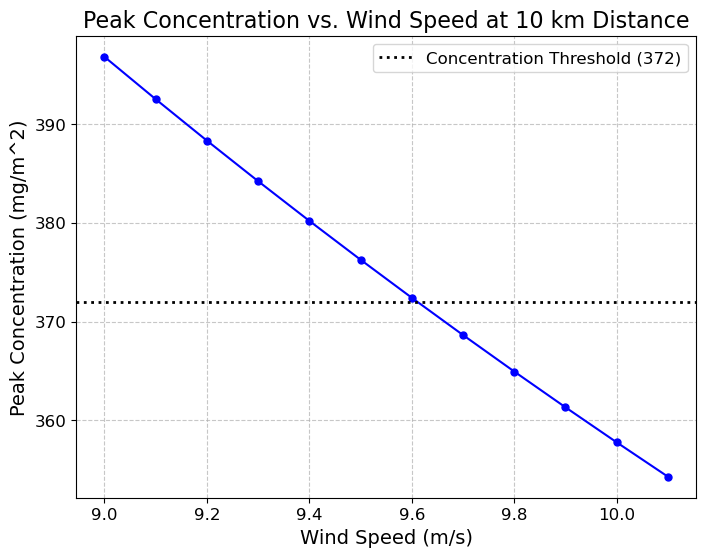

In [5]:
# Create Storage List for Maximum Concentration
max_at_10 = []

# Loop to run numerical scheme for each wind speed
for u in windspeeds:
    c_old_flat = IC_flat # Get initial condition in flattened form
    C = np.zeros((Nt,Nx * Ny))  # Create concentration matrix for storage
    C[0, :] = c_old_flat    # Insert initial condition
    A_matrix = matrix_cons(u)   # Construct tridiagonal matrix
    
    # Compute LU Decomposition and create preconditioner for faster computation
    A_LU = spilu(A_matrix)
    preconditioner = LinearOperator(A_matrix.shape, lambda b: A_LU.solve(b))
    
    # Solve at each time step
    for t in range(1, Nt):
        
        RHS = c_old_flat
        c_new_flat, _ = gmres(A_matrix, RHS, M = preconditioner) # Solve Ax=b using Generalized Minimal Residual iteration
        
        # Repuff at every time step
        c_new_flat += IC_flat
        
        # Update the old concentration with the new one
        c_old_flat = c_new_flat.copy()

        # Update Storage Matrix
        C[t, :] = c_new_flat
        
    
    C_correct = C.reshape((Nt, Ny, Nx), order = "C")
    max_at_10.append(np.max(C_correct[:,:, 10 * Space_Resolution ]))

# Convert wind speed back to m/s
wind_speeds_m_s = windspeeds / 3.6 

# Create the plot
plt.figure(figsize = (8, 6))
plt.plot(wind_speeds_m_s, max_at_10, marker='o', linestyle='-', color='b', markersize = 5)
plt.title("Peak Concentration vs. Wind Speed at 10 km Distance", fontsize = 16)
plt.xlabel("Wind Speed (m/s)", fontsize = 14)
plt.ylabel("Peak Concentration (mg/m^2)", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# Specify Concentration Threshold
plt.axhline(y=372, color = 'black', linestyle = ':', linewidth = 2, label = 'Concentration Threshold (372)')
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.legend(fontsize = 12)
plt.savefig("wind_speed_vs_concentration.png", dpi = 300, bbox_inches = 'tight')
plt.show()

In [6]:
# Conservation of Mass Check
IC_mass = Mass* 60 * 1
End_mass = np.trapz(np.trapz(C_correct[Nt - 1,:,:], dx = dy), dx = dx)

Error = (IC_mass - End_mass) / IC_mass * 100

print(f'Mass Percentage Error: {Error:.3f} %')

Mass Percentage Error: -0.907 %


### Extra Plots for Report

In [7]:
# Test at higher difference wind speeds
windspeeds_anim = [5, 10]
n = 0
for u in windspeeds_anim:
    c_old_flat = IC_flat # Get initial condition in flattened form
    C = np.zeros((Nt,Nx * Ny))  # Create concentration matrix for storage
    C[0, :] = c_old_flat    # Insert initial condition
    A_matrix = matrix_cons(u)   # Construct tridiagonal matrix
    
    # Compute LU Decomposition and create preconditioner for faster computation
    A_LU = spilu(A_matrix)
    preconditioner = LinearOperator(A_matrix.shape, lambda b: A_LU.solve(b))
    
    # Solve at each time step
    for t in range(1, Nt):
        
        RHS = c_old_flat
        c_new_flat, _ = gmres(A_matrix, RHS, M = preconditioner) # Solve Ax=b using Generalized Minimal Residual iteration
        
        # Repuff at every time step
        c_new_flat += IC_flat
        
        # Update the old concentration with the new one
        c_old_flat = c_new_flat.copy()

        # Update Storage Matrix
        C[t, :] = c_new_flat
        
    if n == 0: 
        C_test_5= C.reshape((Nt, Ny, Nx), order = "C")
    else:
        C_test_10= C.reshape((Nt, Ny, Nx), order = "C")
    
    n+=1
    

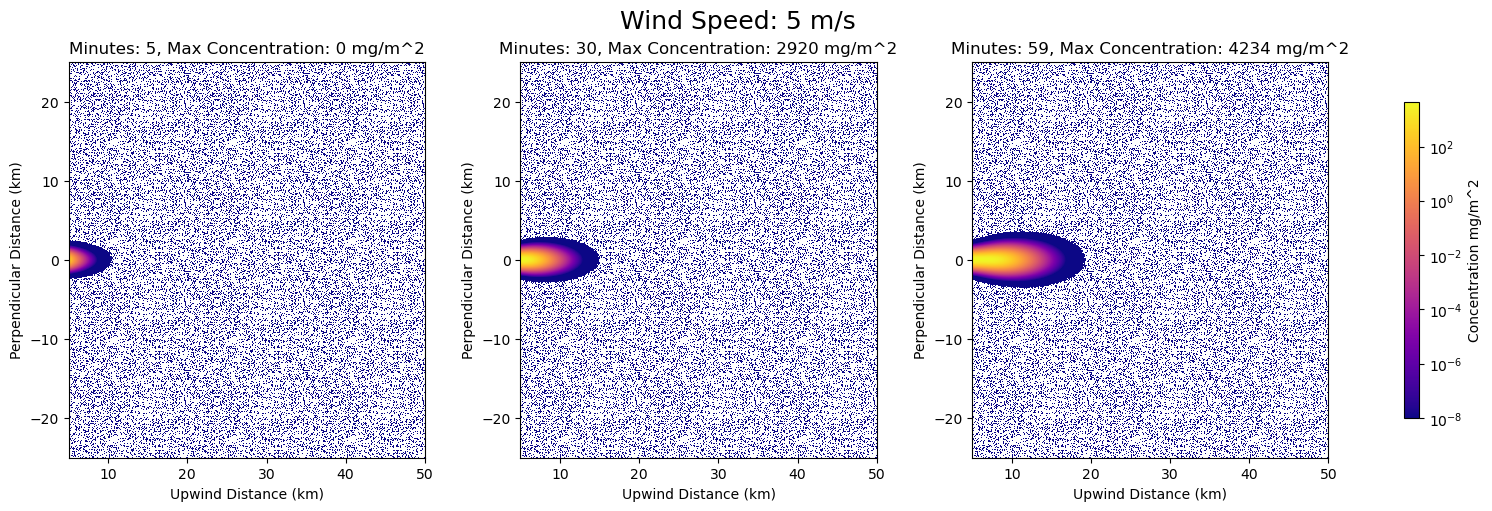

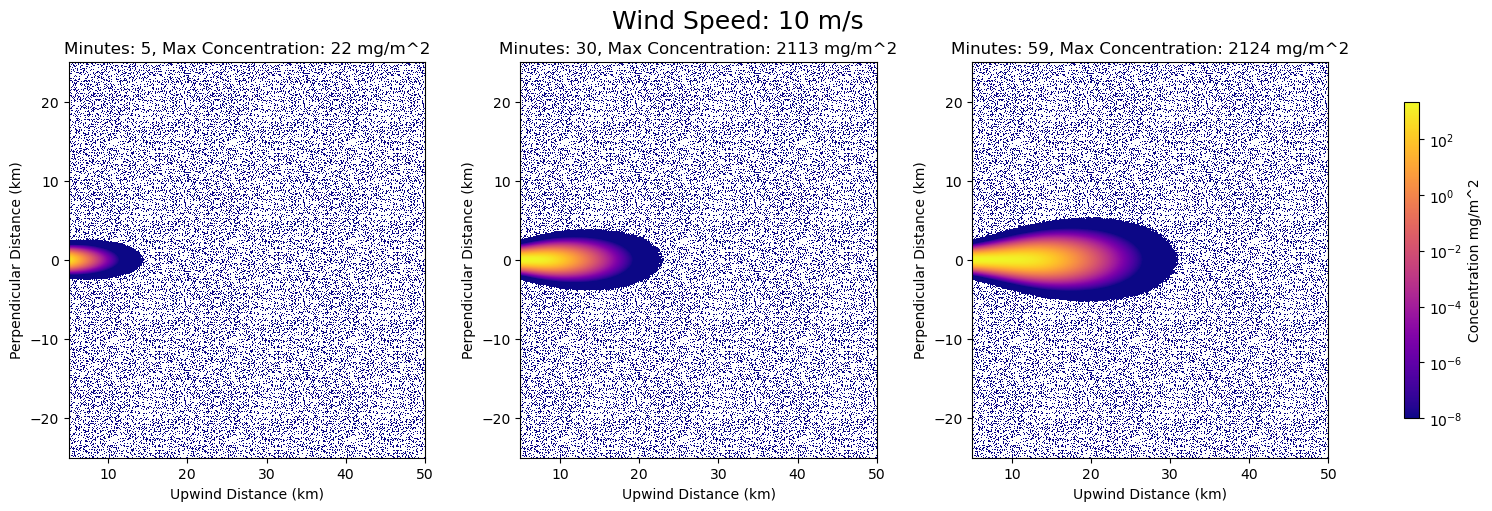

In [8]:
# General Plot parameters
x_dim, y_dim, time_steps = L, L, Nt
plot_times = [5, 30, 59]  # in minutes

# Plot for Wind = 5 m/s
C_anim = C_test_5
wind_speed = windspeeds_anim[0]

# Initialize subplots
fig, axs = plt.subplots(1, len(plot_times), figsize=(15, 5), constrained_layout = True)

for i, time in enumerate(plot_times):
    time_in_minutes = time
    Max_concentration = np.max(C_anim[:time,:,3  * Space_Resolution])
    # Plot the concentration distribution at this time
    cax = axs[i].imshow(C_anim[time, :, 2 * Space_Resolution:], cmap='plasma', 
                        origin='lower', extent=[5, x_dim, -y_dim // 2, y_dim // 2],norm=LogNorm(vmin=1e-8, vmax=np.max(C_anim[:,:,2 * Space_Resolution:])))
    axs[i].set_title(f'Minutes: {time_in_minutes}, Max Concentration: {Max_concentration:.0f} mg/m^2')
    axs[i].set_xlabel('Upwind Distance (km)')
    axs[i].set_ylabel('Perpendicular Distance (km)')


fig.colorbar(cax, ax=axs, label='Concentration mg/m^2', orientation='vertical', shrink = 0.8)
fig.suptitle(f'Wind Speed: {wind_speed} m/s', fontsize = 18)
fig.savefig(f"Concentration_wind_{wind_speed}.png", dpi=300, bbox_inches="tight")

plt.show()

# Plot for Wind = 10 m/s
C_anim = C_test_10
wind_speed = windspeeds_anim[1]

# Initialize subplots
fig, axs = plt.subplots(1, len(plot_times), figsize=(15, 5), constrained_layout = True)

for i, time in enumerate(plot_times):
    time_in_minutes = time
    Max_concentration = np.max(C_anim[:time,:,3  * Space_Resolution])
    # Plot the concentration distribution at this time
    cax = axs[i].imshow(C_anim[time, :, 2 * Space_Resolution:], cmap='plasma', 
                        origin='lower', extent=[5, x_dim, -y_dim // 2, y_dim // 2],norm=LogNorm(vmin=1e-8, vmax=np.max(C_anim[:,:,2 * Space_Resolution:])))
    axs[i].set_title(f'Minutes: {time_in_minutes}, Max Concentration: {Max_concentration:.0f} mg/m^2')
    axs[i].set_xlabel('Upwind Distance (km)')
    axs[i].set_ylabel('Perpendicular Distance (km)')


fig.colorbar(cax, ax=axs, label='Concentration mg/m^2', orientation='vertical', shrink = 0.8)
fig.suptitle(f'Wind Speed: {wind_speed} m/s', fontsize = 18)
fig.savefig(f"Concentration_wind_{wind_speed}.png", dpi=300, bbox_inches="tight")


plt.show()


### Animations of Plume Effect

MovieWriter ffmpeg unavailable; using Pillow instead.


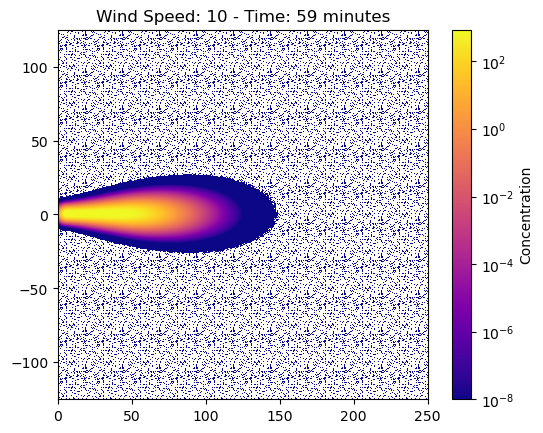

In [16]:

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# For this Wind Speed
A = windspeeds_anim[1]

# write out dimensions
x_dim, y_dim, time_steps = Nx//2, Ny//2, Nt

# Update step for every n minutes
t_start = 0
update_interval = 1
time_steps = Nt // update_interval  # Total frames required
start_frame = t_start // update_interval  # Calculate the starting frame
total_frames = (Nt - t_start) // update_interval  # Total frames from t_start to the end

# Create figure and axes for the plot
fig, ax = plt.subplots()
cax = ax.imshow(C_anim[time, :, :], cmap='plasma', 
                        origin='lower', extent=[0, x_dim, -y_dim // 2, y_dim // 2],norm=LogNorm(vmin=1e-8, vmax=np.max(C_anim[:,:,10 * Space_Resolution:])))
fig.colorbar(cax, ax=ax, label='Concentration')

# Function to update the plot for each frame
def update(frame):
    # Calculate actual time in minutes from t_start
    time_in_minutes = t_start + frame * update_interval
    
    if time_in_minutes >= Nt:  # Ensures we don't exceed bounds
        time_in_minutes = Nt - 1
    hours = time_in_minutes // 60
    minutes = time_in_minutes % 60
    ax.set_title(f'Wind Speed: {A} - Time: {minutes} minutes')
    cax.set_array(C_anim[time_in_minutes, :, :])
    return cax

# Create animation and save as gif
anim = FuncAnimation(fig, update, frames=time_steps, interval=1000)
anim.save(f'concentration_simulation_{A}_wind.gif', fps=10)
plt.show()